In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import networkx as nx
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, acf, q_stat
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import add_constant
from arima_model_function import arima_model, plot_arima_results, plot_pacf_for_arima, plot_acf_for_arima, plot_ar_lag_coefficients

C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
def can_cpi_df_setup(url):
    df = pd.read_csv(url)
    df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])
    df = df[(df['REF_DATE'].dt.year >= 2015) & (df['REF_DATE'].dt.year < 2020)]
    # Change date name to match the US dataset
    df = df.rename(columns = {'REF_DATE': 'Date'})
    df = df[df['GEO'] == 'Canada']
    return df

In [3]:
can_cpi_df = can_cpi_df_setup(r"C:\Users\aswir\OneDrive\Documents\Capstone Project\18100004.csv")
can_cpi_df.head()

C:\Users\aswir\AppData\Local\Temp\ipykernel_20580\3103944337.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,Date,GEO,DGUID,Products and product groups,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
868614,2015-01-01,Canada,2016A000011124,All-items,2002=100,17,units,0,v41690973,2.2,124.3,NaN,NaN,NaN,1
868615,2015-01-01,Canada,2016A000011124,Food,2002=100,17,units,0,v41690974,2.3,139.1,NaN,NaN,NaN,1
868616,2015-01-01,Canada,2016A000011124,Food purchased from stores,2002=100,17,units,0,v41690975,2.4,139.7,NaN,NaN,NaN,1
868617,2015-01-01,Canada,2016A000011124,Meat,2002=100,17,units,0,v41690976,2.5,153.8,NaN,NaN,NaN,1
868618,2015-01-01,Canada,2016A000011124,Fresh or frozen meat (excluding poultry),2002=100,17,units,0,v41690977,2.6,163.1,NaN,NaN,NaN,1


In [4]:
#First six rows are unneeded meta data describing other things
mapping_df = pd.read_csv(r"C:\Users\aswir\OneDrive\Documents\Capstone Project\18100004_MetaData.csv", skiprows=6)

#first 29 rows are related to provinces and locations which we are not interested in
mapping_df = mapping_df.iloc[29:].reset_index(drop=True)
#final df has the member_id and the parent_id which I can use to map each group to it's overall category

mapping_df.drop(columns=['Member Notes', 'Member Definitions', 'Classification Code', 'Terminated'], inplace=True)

mapping_df['Member ID'] = pd.to_numeric(mapping_df['Member ID'], errors='coerce').astype('Int64')  # Use 'Int64' to preserve NaNs
mapping_df['Parent Member ID'] = pd.to_numeric(mapping_df['Parent Member ID'], errors='coerce').astype('Int64')  # Use 'Int64' to preserve NaNs

mapping_df.head(10)

,Dimension ID,Member Name,Member ID,Parent Member ID
0,1,Canada,2,<NA>
1,2,"Recreation, education and reading",219,2
2,2,"Alcoholic beverages, tobacco products and recr...",256,2
3,2,Food,3,2
4,2,Shelter,79,2
5,2,"Household operations, furnishings and equipment",96,2
6,2,Clothing and footwear,139,2
7,2,Transportation,176,2
8,2,Health and personal care,201,2
9,2,Food purchased from stores,4,3


In [5]:
def get_base_children(df, parent_member_id):
    base_children_df = df.loc[df['Parent Member ID'] == parent_member_id, ['Member Name', 'Member ID']]

    base_children_names = base_children_df['Member Name'].to_list()
    base_children_ids = base_children_df['Member ID'].to_list()


    parent_name = df.loc[df['Member ID'] == parent_member_id, 'Member Name'].to_list()
    parent_name = parent_name[-1]

    base_children_names.append(parent_name)
    base_children_ids.append(parent_member_id)

    return base_children_names, base_children_ids

In [6]:
base_categories = get_base_children(mapping_df,139)[0]
base_category_ids = get_base_children(mapping_df, 139)[1]
print(base_categories)
print(base_category_ids)

['Clothing', 'Footwear', 'Clothing accessories, watches and jewellery', 'Clothing material, notions and services', 'Clothing and footwear']
[140, 161, 166, 171, 139]


In [7]:
categories = ['Food','Food purchased from restaurants', 'Food purchased from stores', 'Fish, seafood and other marine products', 'Dairy products and eggs', 'Meat',
              'Shelter', 'Owned accommodation', 'Rented Accomodation', 'Water, gas and electricity',
              'Clothing and Footwear', 'Footwear', 'Clothing', 'Clothing accessories, watches and jewelry',
              'Transportation', 'Public transportation', 'Private transportation', 'Gasoline']

In [8]:
def prepare_categories(df, categories):
    pivoted_df = df[df['Products and product groups'].isin(categories)][['Date', 'Products and product groups', 'VALUE']].pivot(
        index='Date', columns='Products and product groups', values='VALUE')
    return pivoted_df

In [9]:
can_categories_df = prepare_categories(can_cpi_df, categories)
print(len(can_categories_df))
print("Base Categories:", categories)
print("DataFrame Columns:", can_categories_df.columns.tolist())

60
Base Categories: ['Food', 'Food purchased from restaurants', 'Food purchased from stores', 'Fish, seafood and other marine products', 'Dairy products and eggs', 'Meat', 'Shelter', 'Owned accommodation', 'Rented Accomodation', 'Water, gas and electricity', 'Clothing and Footwear', 'Footwear', 'Clothing', 'Clothing accessories, watches and jewelry', 'Transportation', 'Public transportation', 'Private transportation', 'Gasoline']
DataFrame Columns: ['Clothing', 'Dairy products and eggs', 'Fish, seafood and other marine products', 'Food', 'Food purchased from restaurants', 'Food purchased from stores', 'Footwear', 'Gasoline', 'Meat', 'Owned accommodation', 'Private transportation', 'Public transportation', 'Shelter', 'Transportation']


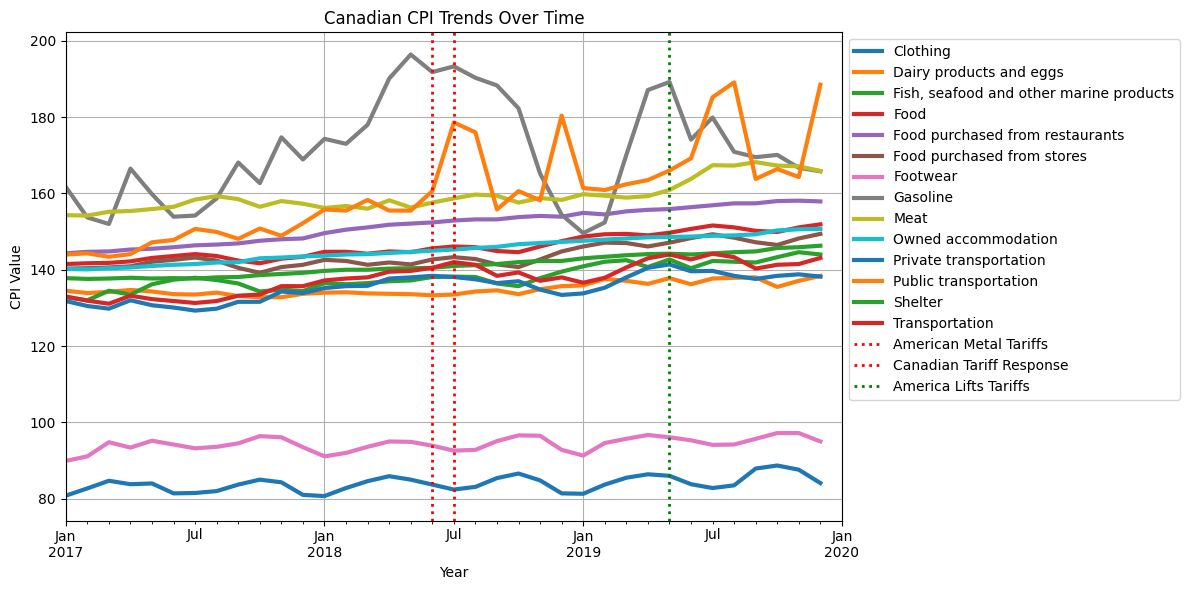

In [10]:
plt.figure(figsize=(12, 6))

# Plot all categories at once
can_categories_df.plot(ax=plt.gca(), linewidth=3)

# Formatting
plt.axvline(pd.Timestamp("2018-06-01"), color="red", linestyle="dotted", linewidth=2, label="American Metal Tariffs")
plt.axvline(pd.Timestamp("2018-07-01"), color="red", linestyle="dotted", linewidth=2, label="Canadian Tariff Response")
plt.axvline(pd.Timestamp("2019-05-17"), color="green", linestyle="dotted", linewidth=2, label="America Lifts Tariffs")

plt.xlabel("Year")
plt.xlim(pd.Timestamp("2017-01-01"), pd.Timestamp("2020-01-01"))
plt.ylabel("CPI Value")
plt.title("Canadian CPI Trends Over Time")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
model = arima_model(can_categories_df, 'Shelter', (10,1,2), '2018-06-01', 8, 8)

plot_ar_lag_coefficients('Shelter', model, alpha=0.05)

['ar', 'ma', 'variance']
[ 1.          0.05985114 -0.78840067 -0.40241523 -0.03974631  0.17991657
  0.24149716  0.25438602  0.03647318 -0.13513612 -0.39199835]

📊 **Augmented Dickey-Fuller (ADF) Test on Differenced Data:**
  p-value: 0.0000 (Stationary ✅)

📊 **In-Sample Evaluation Metrics**
    MAE = 0.0815, MAEP = 0.06%
    RMSE = 0.1063

**Ljung-Box Test (Residuals Autocorrelation):**
  p-value: 0.3740 (No autocorrelation ✅)

📊 **Breusch-Pagan Test (Heteroskedasticity):**
  p-value: 0.9274 (Homoskedastic ✅)

📊 **Model Selection Criteria:**
  AIC: 3.0205


C:\Users\aswir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AttributeError: 'tuple' object has no attribute 'polynomial_ar'

In [ ]:
plot_pacf_for_arima(can_categories_df, 'Shelter', lags=20)

TypeError: plot_pacf_for_arima() missing 1 required positional argument: 'model'